<a href="https://colab.research.google.com/github/Chay16/dataflowr-PlutonAI/blob/master/05_collaborative_filtering_PlutonAI_1M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative filtering: refactoring the code
-----

In this practical, you will need to refactor the code seen during the lesson in order to deal with the [Movielens 1M Dataset](https://grouplens.org/datasets/movielens/1m/)

## 1. Preparations

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed:
data_folder = '/content/'


ML_1M_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-1m')

In [0]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

## 2. Data analysis and formating

As in the lesson, we start by loading the data with [Python Data Analysis Library](http://pandas.pydata.org/)

In [3]:
import pandas as pd
all_ratings = pd.read_csv(op.join(ML_1M_FOLDER, 'ratings.dat'), sep='::',
                          names=["user_id", "item_id", "ratings", "timestamp"],engine='python')
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_1M_FOLDER, 'movies.dat'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('::')[0])
        list_movies_names.append(line.split('::')[1])
        
movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)), 
               columns =['item_id', 'item_name']) 
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we add the title of the movies to the data.

In [0]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)
all_ratings = all_ratings.merge(movies_names,on='item_id')

In [6]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975)


The dataframe `all_ratings` contains all the raw data for our problem.

In [7]:
#number of entries
len(all_ratings)

1000209

In [8]:
all_ratings['ratings'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [9]:
all_ratings['ratings'].unique()

array([5, 4, 3, 2, 1])

In [10]:
all_ratings['user_id'].describe()

count    1.000209e+06
mean     3.024512e+03
std      1.728413e+03
min      1.000000e+00
25%      1.506000e+03
50%      3.070000e+03
75%      4.476000e+03
max      6.040000e+03
Name: user_id, dtype: float64

In [11]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

6040


We see that as in the lesson, the users seem to be indexed from 1 to 6040. Let's check that below.

In [0]:
list_user_id = list(all_ratings['user_id'].unique())
list_user_id.sort()

In [0]:
for i,j in enumerate(list_user_id):
    if j != i+1:
        print(i,j) 

We create a new column `user_num` to get an index from 0 to 6039 for users:

In [0]:
all_ratings['user_num'] = all_ratings['user_id'].apply(lambda x :x-1)

In [15]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16


We now look at movies.

In [16]:
all_ratings['item_id'].describe()

count    1.000209e+06
mean     1.865540e+03
std      1.096041e+03
min      1.000000e+00
25%      1.030000e+03
50%      1.835000e+03
75%      2.770000e+03
max      3.952000e+03
Name: item_id, dtype: float64

In [17]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

3706


Here there is a clear problem: there are 3706 different movies but the range of `item_id` starts at 1 and ends at 3952. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 3705.

In [0]:
#
# your code here
item_id_to_item_num = {}

item_num = 0
for item_id in sorted(all_ratings['item_id'].unique()):
    item_id_to_item_num[item_id] = item_num
    item_num += 1

all_ratings['item_num'] = all_ratings['item_id'].apply(lambda x :item_id_to_item_num[x])
#

This function will verify that your result is correct.

In [0]:
def check_ratings_num(df):
    item_num = set(df['item_num'])
    if item_num == set(range(len(item_num))):
        return True
    else:
        return False

In [20]:
check_ratings_num(all_ratings)

True

In [21]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num,item_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,1104
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1,1104
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11,1104
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14,1104
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16,1104


Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [0]:
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(all_ratings, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

## 3. The model

We will now modify a bit the `FactorizationModel` class seen during the lesson. Internally, we will still use the `Model_dot` but now we use the PyTorch dataloader.

In [0]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def df_2_tensor(df, device):
    # return a triplet user_num, item_num, rating from the dataframe
    user_num = np.asarray(df['user_num'])
    item_num = np.asarray(df['item_num'])
    rating = np.asarray(df['ratings'])
    return torch.from_numpy(user_num).to(device), torch.from_numpy(item_num).to(device), torch.from_numpy(rating).to(device)

Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [0]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

We now do the same thing for the validation and test sets.

In [0]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

The code below is taken from the lesson

In [0]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the emedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [0]:
class DotModel(nn.Module):
    
    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):
        
        super(DotModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)
                
        
    def forward(self, user_ids, item_ids):
        #
        # your code
        x = (self.user_embeddings(user_ids) * self.item_embeddings(item_ids)).sum(1)
        x = x + self.user_biases(user_ids).squeeze() + self.item_biases(item_ids).squeeze()
        #
        return x

In [0]:
net = DotModel(total_user_id,total_item_id).to(device)

Now test your network on a small batch.

In [31]:
predicitions = net(train_user_num[:5], train_item_num[:5])
predicitions

tensor([-0.0077, -0.0014,  0.0099, -0.0025,  0.0071], device='cuda:0',
       grad_fn=<AddBackward0>)

In [0]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [33]:
loss_fn = regression_loss
loss = loss_fn(predicitions, train_rating[:5])
loss

tensor(11.9857, device='cuda:0', grad_fn=<MeanBackward0>)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list; then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling. We will not use anymore the functions `shuffle` and `minibatch` used in the lesson.

In [0]:
def tensor_2_dataset(user,item,rating):
    # your code here
    return [(u,i,r) for u,i,r in zip(user,item,rating)]
    
def make_dataloader(dataset,bs,shuffle):
    # your code here
    return torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=shuffle)
    

In [0]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

In [0]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

Here you need to modify the code seen during the lesson:
 - remove the batch_size in the init
 - the fit function should now take as argument a dataloader for the training and a dataloader for the validation. AT the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

In [0]:
class FactorizationModel(object):
    
    def __init__(self, embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):
        
        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()
             
        
    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)
        
        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )
        
        self._loss_func = regression_loss
        
    
    @property
    def _initialized(self):
        return self._optimizer is not None
    
    def __repr__(self):
        return _repr_model(self)
    
    def fit(self, dataloader, val_dataloader, verbose=True):       
        if not self._initialized:
            self._initialize()
            
        for epoch_num in range(self._n_iter):
            epoch_loss = 0.0
            self._net.train(True)

            #
            # your code
            size = 0
            for batch_user, batch_item, batch_rating in dataloader:
                size += 1
                predictions = self._net(batch_user, batch_item)
                self._optimizer.zero_grad()
                loss = self._loss_func(predictions, batch_rating)
                epoch_loss += loss.data.item() 
                loss.backward()
                self._optimizer.step() 
            #
                
            
            epoch_loss = epoch_loss / size
            loss_test = self.test(val_dataloader)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num, epoch_loss,loss_test))
        
            if np.isnan(epoch_loss) or epoch_loss == 0.0:
                raise ValueError('Degenerate epoch loss: {}'
                                 .format(epoch_loss))
    
    
    def test(self,dataloader, verbose = False):
        self._net.train(False)
        L1loss = torch.nn.L1Loss()
        test_loss = 0.0
        test_mae = 0.0
        #
        # your code here (mae = mean absolute error)
        size = 0
        for batch_user, batch_item, batch_rating in dataloader:
            size += 1
            predictions = self._net(batch_user, batch_item)
            loss = self._loss_func(predictions, batch_rating)
            test_loss += loss.data.item()
            test_mae += mean_absolute_error(predictions.data.cpu(), batch_rating.data.cpu())
            
        #
                
        test_loss = test_loss / size
        test_mae = test_mae / size
        if verbose:
            print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}")
        return loss.item()

In [0]:
model = FactorizationModel(embedding_dim=50,  # latent dimensionality
                                   n_iter=15,  # number of epochs of training
                                   learning_rate=5e-4,
                                   l2=1e-9,  # strength of L2 regularization
                                   num_users=total_user_id,
                                   num_items=total_item_id)

In [39]:
model.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 10.33345668123226, loss_val 3.0832438468933105
Epoch 1: loss_train 1.7026778891532108, loss_val 1.078348994255066
Epoch 2: loss_train 0.9799523613970689, loss_val 0.9061328172683716
Epoch 3: loss_train 0.8688437166539106, loss_val 0.8746346831321716
Epoch 4: loss_train 0.8349683765660633, loss_val 0.8598342537879944
Epoch 5: loss_train 0.8186973597515713, loss_val 0.8399873375892639
Epoch 6: loss_train 0.8070514219427349, loss_val 0.8330771923065186
Epoch 7: loss_train 0.797270866430769, loss_val 0.829879879951477
Epoch 8: loss_train 0.7886540317776227, loss_val 0.809420645236969
Epoch 9: loss_train 0.7810259958108267, loss_val 0.80266273021698
Epoch 10: loss_train 0.7737668605916428, loss_val 0.8088446259498596
Epoch 11: loss_train 0.7671417686523814, loss_val 0.8037886023521423
Epoch 12: loss_train 0.7600991141916525, loss_val 0.7983860969543457
Epoch 13: loss_train 0.7530759811551884, loss_val 0.7895199656486511
Epoch 14: loss_train 0.7451453357934952, loss_val 0

In [40]:
_= model.test(test_dataloader,True)

RMSE: 0.8814971298485808, MAE: 0.694267358663003


Play with the parameter to beat the benchmarks presented here: [Surprise](https://github.com/NicolasHug/Surprise)

## 4. Best and worst movies

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

In [41]:
from tqdm.notebook import tqdm as tq

item_bias_np = model._net.item_biases.weight.data.cpu().numpy()

movies_biases = []

for i, bias in tq(enumerate(item_bias_np)):
    movies_biases.append([all_ratings[all_ratings['item_num']==i].item_name.unique()[0], bias[0]])
movies_biases.sort(key=lambda movies_biases:movies_biases[1], reverse=True)

In [42]:
print("10 Best movies :")
for movie_name, bias in movies_biases[:10]:
    print("{} - bias : {:.3f}".format(movie_name, bias))
print("")
print("10 Worst movies :")
for movie_name, bias in movies_biases[-10:]:
    print("{} - bias : {:.3f}".format(movie_name, bias))

10 Best movies :
Star Wars: Episode IV - A New Hope (1977) - bias : 0.477
Sixth Sense, The (1999) - bias : 0.476
Schindler's List (1993) - bias : 0.473
Shawshank Redemption, The (1994) - bias : 0.470
Raiders of the Lost Ark (1981) - bias : 0.466
Matrix, The (1999) - bias : 0.453
Silence of the Lambs, The (1991) - bias : 0.448
American Beauty (1999) - bias : 0.446
Usual Suspects, The (1995) - bias : 0.443
Godfather, The (1972) - bias : 0.438

10 Worst movies :
Joyriders, The (1999) - bias : 0.000
Spiders, The (Die Spinnen, 1. Teil: Der Goldene See) (1919) - bias : 0.000
White Boys (1999) - bias : 0.000
Spring Fever USA (a.k.a. Lauderdale) (1989) - bias : 0.000
Alley Cats, The (1968) - bias : 0.000
Match, The (1999) - bias : 0.000
Project Moon Base (1953) - bias : 0.000
Skipped Parts (2000) - bias : 0.000
Back Stage (2000) - bias : 0.000
Uninvited Guest, An (2000) - bias : 0.000


## 5. PCA of movies' embeddings

Now you can also plpay with the embeddings learned by your algorithm for the movies.

In [0]:
from sklearn.decomposition import PCA
from operator import itemgetter

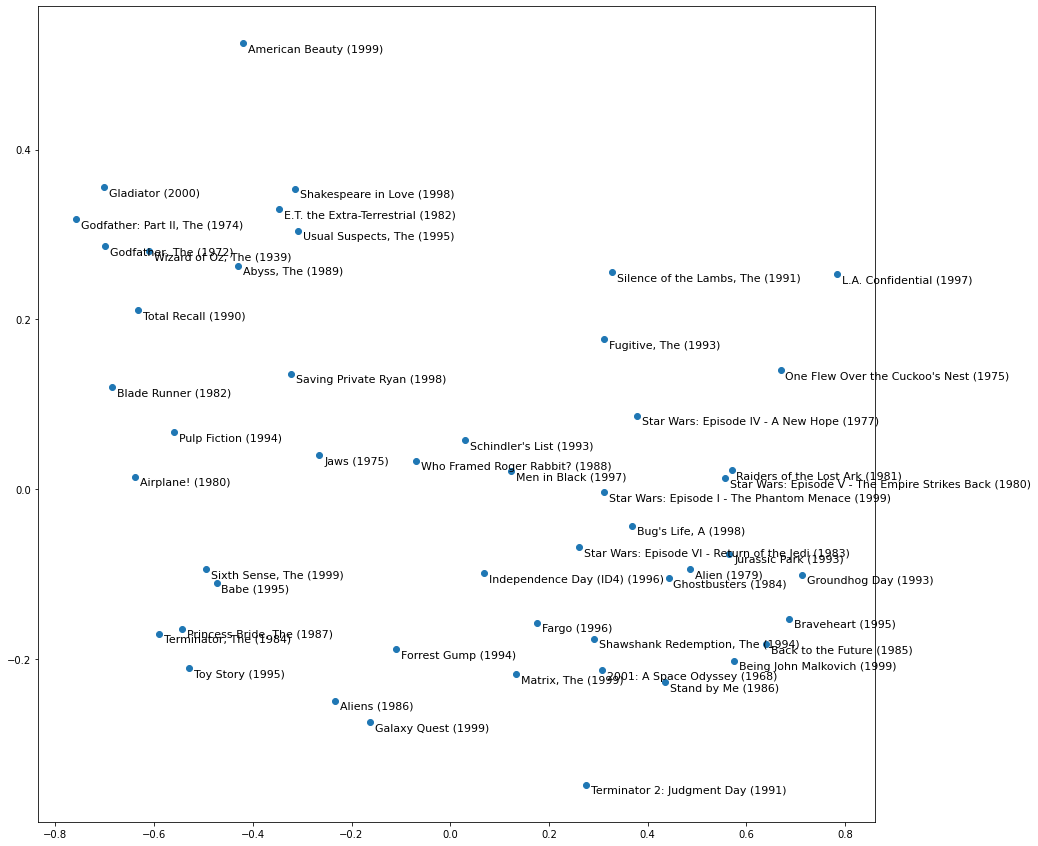

In [44]:
item_emb_np = model._net.item_embeddings.weight.data.cpu().numpy()

pca = PCA(n_components=3)
latent_fac = pca.fit_transform(item_emb_np)
movie_comp = [(f, i) for f,i in zip(latent_fac[:,1], list_movies_names)]
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
idxs = range(50)
txt_movies_names = most_rated_movies[:len(idxs)]
X = latent_fac[idxs,0]
Y = latent_fac[idxs,2]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()